In [1]:
import xgboost as xgb
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.linear_model import ElasticNet
import calendar
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
all_df_imputed = pd.read_csv(".\\data\\processed_new\\all_data_imputed.csv")
all_df_imputed["Date"] = pd.to_datetime(all_df_imputed.Date).dt.date

ow_data = all_df_imputed[all_df_imputed['Date'] >= datetime.date(2020, 11, 24)].drop(columns=["NO2_gov", "NO2_sat", "CO_gov", "CO_sat", "PM2_5_gov", "PM2_5_sat", "SO2_gov", "SO2_sat", 'retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential'])
pre_dates = all_df_imputed[all_df_imputed['Date'] < datetime.date(2020, 11, 24)]["Date"]
pre_cities = all_df_imputed[all_df_imputed['Date'] < datetime.date(2020, 11, 24)]["City"]

all_df_imputed["Date"] = [calendar.timegm(i.timetuple()) for i in all_df_imputed["Date"]]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(all_df_imputed["City"].values.reshape(-1, 1))
ohe = pd.DataFrame(enc.transform(all_df_imputed["City"].values.reshape(-1, 1)))
all_df_imputed = pd.concat([ohe, all_df_imputed.drop(columns="City")], axis=1, ignore_index=False)

In [3]:
all_df_imputed_pre = all_df_imputed[(all_df_imputed['Date'] < calendar.timegm(datetime.date(2020, 11, 24).timetuple()))].drop(["CO_ow", "NO2_ow", "SO2_ow", "PM2_5_ow"], axis=1)
all_df_imputed_2020 = all_df_imputed[(all_df_imputed['Date'] >= calendar.timegm(datetime.date(2020, 11, 24).timetuple())) & (all_df_imputed['Date'] <= calendar.timegm(datetime.date(2021, 12, 31).timetuple()))]
all_df_imputed_2022 = all_df_imputed[(all_df_imputed['Date'] >= calendar.timegm(datetime.date(2022, 1, 1).timetuple()))]

In [4]:
def train_xgb(train_X, train_y, test_X, test_y):
    test_scores = []
    potential_n_estimators = [10, 100, 1000, 10000]
    potential_max_depths = [1, 10, 100, 1000]
    for n_estimators in potential_n_estimators:
        for max_depth in potential_max_depths:
            model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, max_depth=max_depth)
            model.fit(train_X, train_y)
            
            test_preds = model.predict(test_X)
            test_mse = np.mean((test_preds - test_y)**2)
            test_scores.append(test_mse)
            
    optimal_ind = np.argmin(test_scores)
    optimal_n_estimators, optimal_max_depth = list(product(potential_n_estimators, potential_max_depths))[optimal_ind]
    print(min(test_scores), optimal_n_estimators, optimal_max_depth)
    return optimal_n_estimators, optimal_max_depth

In [5]:
def train_elnet(train_X, train_y, test_X, test_y):
    test_scores = []
    potential_alphas = [0.5, 1, 2, 4, 10, 100]
    potential_l1s = [0, 0.25, 0.5, 0.75, 1]
    for alpha in potential_alphas:
        for l1 in potential_l1s:
            model = ElasticNet(alpha=alpha, l1_ratio=l1)
            model.fit(train_X, train_y)
            
            test_preds = model.predict(test_X)
            test_mse = np.mean((test_preds - test_y)**2)
            test_scores.append(test_mse)
            
    optimal_ind = np.argmin(test_scores)
    optimal_alpha, optimal_l1 = list(product(potential_alphas, potential_l1s))[optimal_ind]
    print(min(test_scores), optimal_alpha, optimal_l1)
    return optimal_alpha, optimal_l1

In [6]:
def train_knn(train_X, train_y, test_X, test_y):
    test_scores = []
    potential_ks = [1, 10, 100, 500, 1000]
    for k in potential_ks:
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(train_X, train_y)

        test_preds = model.predict(test_X)
        test_mse = np.mean((test_preds - test_y)**2)
        test_scores.append(test_mse)
            
    optimal_ind = np.argmin(test_scores)
    optimal_k = potential_ks[optimal_ind]
    print(min(test_scores), optimal_k)
    return optimal_k

# SO2

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


144.17099265631612 100 1


C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


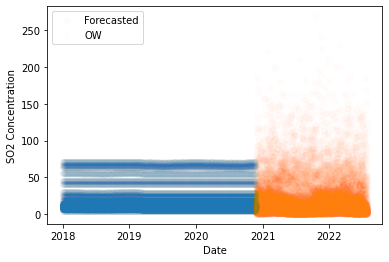

In [7]:
SO2_train_X = all_df_imputed_2020.drop(columns=["SO2_ow", "NO2_ow", "NO2_gov", "NO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
SO2_train_y = all_df_imputed_2020["SO2_ow"]
SO2_test_X = all_df_imputed_2022.drop(columns=["SO2_ow", "NO2_ow", "NO2_gov", "NO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
SO2_test_y = all_df_imputed_2022["SO2_ow"]

scaler = StandardScaler()
SO2_train_X = scaler.fit_transform(SO2_train_X)
SO2_test_X = scaler.transform(SO2_test_X)

optimal_n_estimators, optimal_max_depth = train_xgb(SO2_train_X, SO2_train_y, SO2_test_X, SO2_test_y)

SO2_all_X = np.concatenate([SO2_train_X, SO2_test_X])
SO2_all_y = np.concatenate([SO2_train_y, SO2_test_y])

SO2_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=optimal_n_estimators, max_depth=optimal_max_depth)
SO2_model.fit(SO2_all_X, SO2_all_y)

SO2_pre = all_df_imputed_pre.drop(columns=["NO2_gov", "NO2_sat", "CO_gov", "CO_sat", "PM2_5_gov", "PM2_5_sat"])
SO2_pre = scaler.fit_transform(SO2_pre)
SO2_backcast = SO2_model.predict(SO2_pre)

plt.plot_date(pre_dates, SO2_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["SO2_ow"], label="OW", alpha=0.01)
plt.ylabel("SO2 Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or con

142.01513641703735 0.5 1


C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


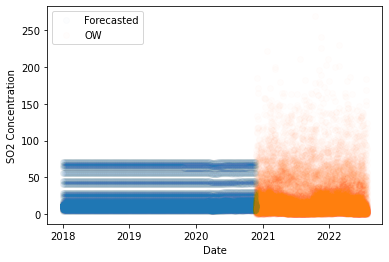

In [8]:
SO2_train_X = all_df_imputed_2020.drop(columns=["SO2_ow", "NO2_ow", "NO2_gov", "NO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
SO2_train_y = all_df_imputed_2020["SO2_ow"]
SO2_test_X = all_df_imputed_2022.drop(columns=["SO2_ow", "NO2_ow", "NO2_gov", "NO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
SO2_test_y = all_df_imputed_2022["SO2_ow"]

scaler = StandardScaler()
SO2_train_X = scaler.fit_transform(SO2_train_X)
SO2_test_X = scaler.transform(SO2_test_X)

optimal_alpha, optimal_l1 = train_elnet(SO2_train_X, SO2_train_y, SO2_test_X, SO2_test_y)

SO2_all_X = np.concatenate([SO2_train_X, SO2_test_X])
SO2_all_y = np.concatenate([SO2_train_y, SO2_test_y])

SO2_model = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1)
SO2_model.fit(SO2_all_X, SO2_all_y)

SO2_pre = all_df_imputed_pre.drop(columns=["NO2_gov", "NO2_sat", "CO_gov", "CO_sat", "PM2_5_gov", "PM2_5_sat"])
SO2_pre = scaler.fit_transform(SO2_pre)
best_SO2_backcast = SO2_model.predict(SO2_pre)

plt.plot_date(pre_dates, best_SO2_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["SO2_ow"], label="OW", alpha=0.01)
plt.ylabel("SO2 Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


145.78561251268556 500


C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


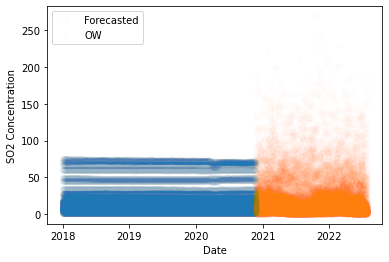

In [9]:
SO2_train_X = all_df_imputed_2020.drop(columns=["SO2_ow", "NO2_ow", "NO2_gov", "NO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
SO2_train_y = all_df_imputed_2020["SO2_ow"]
SO2_test_X = all_df_imputed_2022.drop(columns=["SO2_ow", "NO2_ow", "NO2_gov", "NO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
SO2_test_y = all_df_imputed_2022["SO2_ow"]

scaler = StandardScaler()
SO2_train_X = scaler.fit_transform(SO2_train_X)
SO2_test_X = scaler.transform(SO2_test_X)

optimal_k = train_knn(SO2_train_X, SO2_train_y, SO2_test_X, SO2_test_y)

SO2_all_X = np.concatenate([SO2_train_X, SO2_test_X])
SO2_all_y = np.concatenate([SO2_train_y, SO2_test_y])

SO2_model = KNeighborsRegressor(n_neighbors=optimal_k)
SO2_model.fit(SO2_all_X, SO2_all_y)

SO2_pre = all_df_imputed_pre.drop(columns=["NO2_gov", "NO2_sat", "CO_gov", "CO_sat", "PM2_5_gov", "PM2_5_sat"])
SO2_pre = scaler.fit_transform(SO2_pre)
SO2_backcast = SO2_model.predict(SO2_pre)

plt.plot_date(pre_dates, SO2_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["SO2_ow"], label="OW", alpha=0.01)
plt.ylabel("SO2 Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

# NO2

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


158.58867665214612 1000 1


C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


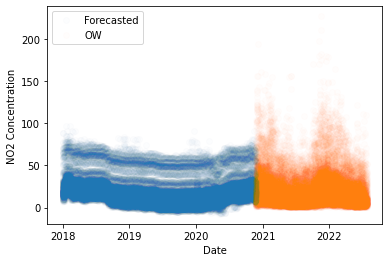

In [10]:
NO2_train_X = all_df_imputed_2020.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
NO2_train_y = all_df_imputed_2020["NO2_ow"]
NO2_test_X = all_df_imputed_2022.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
NO2_test_y = all_df_imputed_2022["NO2_ow"]

scaler = StandardScaler()
NO2_train_X = scaler.fit_transform(NO2_train_X)
NO2_test_X = scaler.transform(NO2_test_X)

optimal_n_estimators, optimal_max_depth = train_xgb(NO2_train_X, NO2_train_y, NO2_test_X, NO2_test_y)

NO2_all_X = np.concatenate([NO2_train_X, NO2_test_X])
NO2_all_y = np.concatenate([NO2_train_y, NO2_test_y])

NO2_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=optimal_n_estimators, max_depth=optimal_max_depth)
NO2_model.fit(NO2_all_X, NO2_all_y)

NO2_pre = all_df_imputed_pre.drop(columns=["SO2_gov", "SO2_sat", "CO_gov", "CO_sat", "PM2_5_gov", "PM2_5_sat"])
NO2_pre = scaler.fit_transform(NO2_pre)
NO2_backcast = NO2_model.predict(NO2_pre)

plt.plot_date(pre_dates, NO2_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["NO2_ow"], label="OW", alpha=0.01)
plt.ylabel("NO2 Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or con

126.99459904640815 0.5 0.75


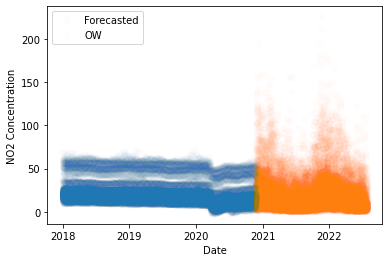

In [11]:
NO2_train_X = all_df_imputed_2020.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
NO2_train_y = all_df_imputed_2020["NO2_ow"]
NO2_test_X = all_df_imputed_2022.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
NO2_test_y = all_df_imputed_2022["NO2_ow"]

scaler = StandardScaler()
NO2_train_X = scaler.fit_transform(NO2_train_X)
NO2_test_X = scaler.transform(NO2_test_X)

optimal_alpha, optimal_l1 = train_elnet(NO2_train_X, NO2_train_y, NO2_test_X, NO2_test_y)

NO2_all_X = np.concatenate([NO2_train_X, NO2_test_X])
NO2_all_y = np.concatenate([NO2_train_y, NO2_test_y])

NO2_model = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1)
NO2_model.fit(NO2_all_X, NO2_all_y)

NO2_pre = all_df_imputed_pre.drop(columns=["SO2_gov", "SO2_sat", "CO_gov", "CO_sat", "PM2_5_gov", "PM2_5_sat"])
NO2_pre = scaler.fit_transform(NO2_pre)
NO2_backcast = NO2_model.predict(NO2_pre)

plt.plot_date(pre_dates, NO2_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["NO2_ow"], label="OW", alpha=0.01)
plt.ylabel("NO2 Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


123.05262462057624 500


C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


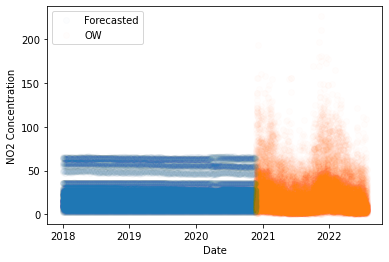

In [12]:
NO2_train_X = all_df_imputed_2020.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
NO2_train_y = all_df_imputed_2020["NO2_ow"]
NO2_test_X = all_df_imputed_2022.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "CO_gov", "CO_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
NO2_test_y = all_df_imputed_2022["NO2_ow"]

scaler = StandardScaler()
NO2_train_X = scaler.fit_transform(NO2_train_X)
NO2_test_X = scaler.transform(NO2_test_X)

optimal_k = train_knn(NO2_train_X, NO2_train_y, NO2_test_X, NO2_test_y)

NO2_all_X = np.concatenate([NO2_train_X, NO2_test_X])
NO2_all_y = np.concatenate([NO2_train_y, NO2_test_y])

NO2_model = KNeighborsRegressor(n_neighbors=optimal_k)
NO2_model.fit(NO2_all_X, NO2_all_y)

NO2_pre = all_df_imputed_pre.drop(columns=["SO2_gov", "SO2_sat", "CO_gov", "CO_sat", "PM2_5_gov", "PM2_5_sat"])
NO2_pre = scaler.fit_transform(NO2_pre)
best_NO2_backcast = NO2_model.predict(NO2_pre)

plt.plot_date(pre_dates, best_NO2_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["NO2_ow"], label="OW", alpha=0.01)
plt.ylabel("NO2 Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

# CO

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


391732.8834899675 1000 1


C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


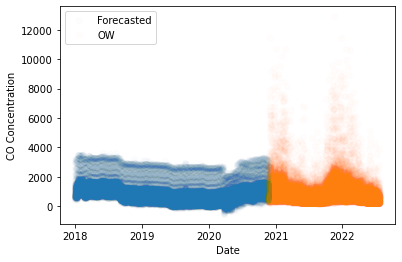

In [13]:
CO_train_X = all_df_imputed_2020.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
CO_train_y = all_df_imputed_2020["CO_ow"]
CO_test_X = all_df_imputed_2022.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
CO_test_y = all_df_imputed_2022["CO_ow"]

scaler = StandardScaler()
CO_train_X = scaler.fit_transform(CO_train_X)
CO_test_X = scaler.transform(CO_test_X)

optimal_n_estimators, optimal_max_depth = train_xgb(CO_train_X, CO_train_y, CO_test_X, CO_test_y)

CO_all_X = np.concatenate([CO_train_X, CO_test_X])
CO_all_y = np.concatenate([CO_train_y, CO_test_y])

CO_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=optimal_n_estimators, max_depth=optimal_max_depth)
CO_model.fit(CO_all_X, CO_all_y)

CO_pre = all_df_imputed_pre.drop(columns=["SO2_gov", "SO2_sat", "NO2_gov", "NO2_sat", "PM2_5_gov", "PM2_5_sat"])
CO_pre = scaler.fit_transform(CO_pre)
CO_backcast = CO_model.predict(CO_pre)

plt.plot_date(pre_dates, CO_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["CO_ow"], label="OW", alpha=0.01)
plt.ylabel("CO Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or con

286608.2003774129 0.5 0.5


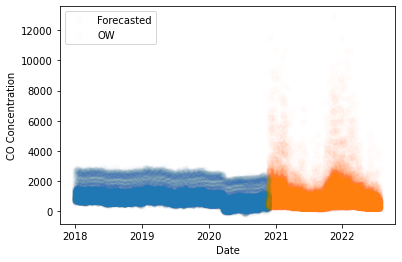

In [14]:
CO_train_X = all_df_imputed_2020.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
CO_train_y = all_df_imputed_2020["CO_ow"]
CO_test_X = all_df_imputed_2022.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
CO_test_y = all_df_imputed_2022["CO_ow"]

scaler = StandardScaler()
CO_train_X = scaler.fit_transform(CO_train_X)
CO_test_X = scaler.transform(CO_test_X)

optimal_alpha, optimal_l1 = train_elnet(CO_train_X, CO_train_y, CO_test_X, CO_test_y)

CO_all_X = np.concatenate([CO_train_X, CO_test_X])
CO_all_y = np.concatenate([CO_train_y, CO_test_y])

CO_model = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1)
CO_model.fit(CO_all_X, CO_all_y)

CO_pre = all_df_imputed_pre.drop(columns=["SO2_gov", "SO2_sat", "NO2_gov", "NO2_sat", "PM2_5_gov", "PM2_5_sat"])
CO_pre = scaler.fit_transform(CO_pre)
best_CO_backcast = CO_model.predict(CO_pre)

plt.plot_date(pre_dates, best_CO_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["CO_ow"], label="OW", alpha=0.01)
plt.ylabel("CO Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


304870.2749037477 500


C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


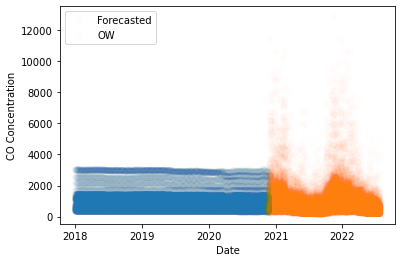

In [15]:
CO_train_X = all_df_imputed_2020.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
CO_train_y = all_df_imputed_2020["CO_ow"]
CO_test_X = all_df_imputed_2022.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "PM2_5_gov", "PM2_5_sat"])
CO_test_y = all_df_imputed_2022["CO_ow"]

scaler = StandardScaler()
CO_train_X = scaler.fit_transform(CO_train_X)
CO_test_X = scaler.transform(CO_test_X)

optimal_k = train_knn(CO_train_X, CO_train_y, CO_test_X, CO_test_y)

CO_all_X = np.concatenate([CO_train_X, CO_test_X])
CO_all_y = np.concatenate([CO_train_y, CO_test_y])

CO_model = KNeighborsRegressor(n_neighbors=optimal_k)
CO_model.fit(CO_all_X, CO_all_y)

CO_pre = all_df_imputed_pre.drop(columns=["SO2_gov", "SO2_sat", "NO2_gov", "NO2_sat", "PM2_5_gov", "PM2_5_sat"])
CO_pre = scaler.fit_transform(CO_pre)
CO_backcast = CO_model.predict(CO_pre)

plt.plot_date(pre_dates, CO_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["CO_ow"], label="OW", alpha=0.01)
plt.ylabel("CO Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

# PM2_5

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


4820.049964148499 1000 1


C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


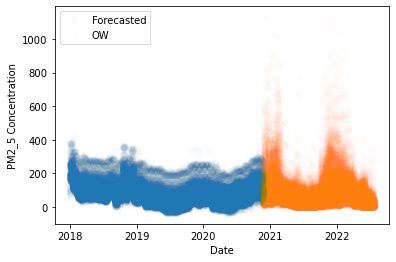

In [16]:
PM2_5_train_X = all_df_imputed_2020.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "CO_gov", "CO_sat"])
PM2_5_train_y = all_df_imputed_2020["PM2_5_ow"]
PM2_5_test_X = all_df_imputed_2022.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "CO_gov", "CO_sat"])
PM2_5_test_y = all_df_imputed_2022["PM2_5_ow"]

scaler = StandardScaler()
PM2_5_train_X = scaler.fit_transform(PM2_5_train_X)
PM2_5_test_X = scaler.transform(PM2_5_test_X)

optimal_n_estimators, optimal_max_depth = train_xgb(PM2_5_train_X, PM2_5_train_y, PM2_5_test_X, PM2_5_test_y)

PM2_5_all_X = np.concatenate([PM2_5_train_X, PM2_5_test_X])
PM2_5_all_y = np.concatenate([PM2_5_train_y, PM2_5_test_y])

PM2_5_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=optimal_n_estimators, max_depth=optimal_max_depth)
PM2_5_model.fit(PM2_5_all_X, PM2_5_all_y)

PM2_5_pre = all_df_imputed_pre.drop(columns=["SO2_gov", "SO2_sat", "NO2_gov", "NO2_sat", "CO_gov", "CO_sat"])
PM2_5_pre = scaler.fit_transform(PM2_5_pre)
PM2_5_backcast = PM2_5_model.predict(PM2_5_pre)

plt.plot_date(pre_dates, PM2_5_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["PM2_5_ow"], label="OW", alpha=0.01)
plt.ylabel("PM2_5 Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or con

4010.211753792892 0.5 0.25


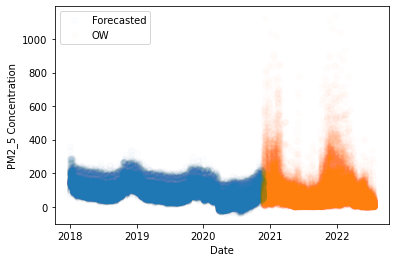

In [17]:
PM2_5_train_X = all_df_imputed_2020.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "CO_gov", "CO_sat"])
PM2_5_train_y = all_df_imputed_2020["PM2_5_ow"]
PM2_5_test_X = all_df_imputed_2022.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "CO_gov", "CO_sat"])
PM2_5_test_y = all_df_imputed_2022["PM2_5_ow"]

scaler = StandardScaler()
PM2_5_train_X = scaler.fit_transform(PM2_5_train_X)
PM2_5_test_X = scaler.transform(PM2_5_test_X)

optimal_alpha, optimal_l1 = train_elnet(PM2_5_train_X, PM2_5_train_y, PM2_5_test_X, PM2_5_test_y)

PM2_5_all_X = np.concatenate([PM2_5_train_X, PM2_5_test_X])
PM2_5_all_y = np.concatenate([PM2_5_train_y, PM2_5_test_y])

PM2_5_model = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1)
PM2_5_model.fit(PM2_5_all_X, PM2_5_all_y)

PM2_5_pre = all_df_imputed_pre.drop(columns=["SO2_gov", "SO2_sat", "NO2_gov", "NO2_sat", "CO_gov", "CO_sat"])
PM2_5_pre = scaler.fit_transform(PM2_5_pre)
best_PM2_5_backcast = PM2_5_model.predict(PM2_5_pre)

plt.plot_date(pre_dates, best_PM2_5_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["PM2_5_ow"], label="OW", alpha=0.01)
plt.ylabel("PM2_5 Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


4272.244531522754 500


C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Nick\anaconda3\envs\pract\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


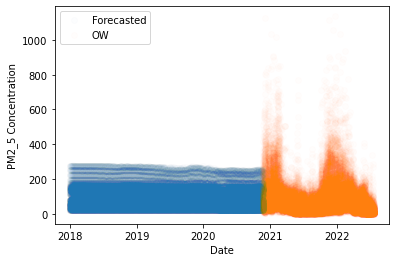

In [18]:
PM2_5_train_X = all_df_imputed_2020.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "CO_gov", "CO_sat"])
PM2_5_train_y = all_df_imputed_2020["PM2_5_ow"]
PM2_5_test_X = all_df_imputed_2022.drop(columns=["NO2_ow", "SO2_ow", "SO2_gov", "SO2_sat", "CO_ow", "NO2_gov", "NO2_sat", "PM2_5_ow", "CO_gov", "CO_sat"])
PM2_5_test_y = all_df_imputed_2022["PM2_5_ow"]

scaler = StandardScaler()
PM2_5_train_X = scaler.fit_transform(PM2_5_train_X)
PM2_5_test_X = scaler.transform(PM2_5_test_X)

optimal_k = train_knn(PM2_5_train_X, PM2_5_train_y, PM2_5_test_X, PM2_5_test_y)

PM2_5_all_X = np.concatenate([PM2_5_train_X, PM2_5_test_X])
PM2_5_all_y = np.concatenate([PM2_5_train_y, PM2_5_test_y])

PM2_5_model = KNeighborsRegressor(n_neighbors=optimal_k)
PM2_5_model.fit(PM2_5_all_X, PM2_5_all_y)

PM2_5_pre = all_df_imputed_pre.drop(columns=["SO2_gov", "SO2_sat", "NO2_gov", "NO2_sat", "CO_gov", "CO_sat"])
PM2_5_pre = scaler.fit_transform(PM2_5_pre)
PM2_5_backcast = PM2_5_model.predict(PM2_5_pre)

plt.plot_date(pre_dates, PM2_5_backcast, label="Forecasted", alpha=0.01)
plt.plot_date(ow_data["Date"], ow_data["PM2_5_ow"], label="OW", alpha=0.01)
plt.ylabel("PM2_5 Concentration")
plt.xlabel("Date")
plt.legend()
plt.show()

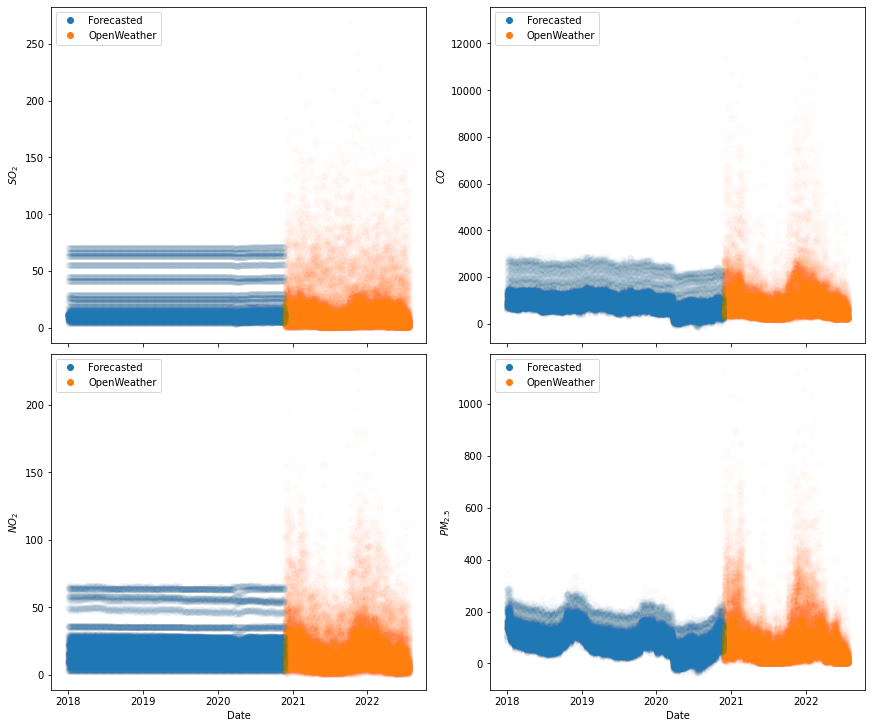

In [25]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 10), layout="constrained", sharex=True)

axs[0,0].plot_date(pre_dates, best_SO2_backcast, label="Forecasted", alpha=0.01)
axs[0,0].plot_date(ow_data["Date"], ow_data["SO2_ow"], label="OpenWeather", alpha=0.01)
axs[0,0].set_ylabel("$SO_2$")
# axs[0,0].set_xlabel("Date")
leg = axs[0,0].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
axs[1,0].plot_date(pre_dates, best_NO2_backcast, label="Forecasted", alpha=0.01)
axs[1,0].plot_date(ow_data["Date"], ow_data["NO2_ow"], label="OpenWeather", alpha=0.01)
axs[1,0].set_ylabel("$NO_2$")
axs[1,0].set_xlabel("Date")
leg = axs[1,0].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
axs[0,1].plot_date(pre_dates, best_CO_backcast, label="Forecasted", alpha=0.01)
axs[0,1].plot_date(ow_data["Date"], ow_data["CO_ow"], label="OpenWeather", alpha=0.01)
axs[0,1].set_ylabel("$CO$")
# axs[0,1].set_xlabel("Date")
leg = axs[0,1].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
axs[1,1].plot_date(pre_dates, best_PM2_5_backcast, label="Forecasted", alpha=0.01)
axs[1,1].plot_date(ow_data["Date"], ow_data["PM2_5_ow"], label="OpenWeather", alpha=0.01)
axs[1,1].set_ylabel("$PM_{2.5}$")
axs[1,1].set_xlabel("Date")
leg = axs[1,1].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
fig.savefig(".\\Plotting\\paper figures\\ow_modeling_city.jpg", dpi=200)

# Saving

In [20]:
backcast_df = pd.DataFrame({"Date":pre_dates, "City":pre_cities, "CO":best_CO_backcast, "NO2":best_NO2_backcast, "SO2":best_SO2_backcast, "PM2_5":best_PM2_5_backcast})
backcast_df

,Date,City,CO,NO2,SO2,PM2_5
0,2018-01-01,Agartala,1032.646088,14.881478,7.419023,213.646563
1,2018-01-01,Agra,1371.458811,24.899601,12.175018,215.263209
2,2018-01-01,Aizwal,910.918580,4.043035,5.735162,94.399025
3,2018-01-01,Amritsar,1538.823961,21.911547,11.056691,219.133226
4,2018-01-01,Asansol,1225.537407,24.798180,25.827534,256.237774
...,...,...,...,...,...,...
57410,2020-11-23,Srinagar,1407.671938,63.352347,15.583994,135.651602
57411,2020-11-23,Thiruvananthapuram,270.991034,2.867883,7.090976,63.068666
57412,2020-11-23,Varanasi,1120.216036,28.313176,12.938345,163.646572
57413,2020-11-23,Vijaywada,475.169543,9.700598,11.481562,95.725398


In [21]:
ow_data2 = ow_data.rename(columns={"CO_ow":"CO", "NO2_ow":"NO2", "SO2_ow":"SO2", "PM2_5_ow":"PM2_5"})
all_pollutant_data = pd.concat([backcast_df, ow_data2])
all_pollutant_data

,Date,City,CO,NO2,SO2,PM2_5
0,2018-01-01,Agartala,1032.646088,14.881478,7.419023,213.646563
1,2018-01-01,Agra,1371.458811,24.899601,12.175018,215.263209
2,2018-01-01,Aizwal,910.918580,4.043035,5.735162,94.399025
3,2018-01-01,Amritsar,1538.823961,21.911547,11.056691,219.133226
4,2018-01-01,Asansol,1225.537407,24.798180,25.827534,256.237774
...,...,...,...,...,...,...
90905,2022-07-25,Srinagar,1544.873750,37.338750,12.002083,64.362917
90906,2022-07-25,Thiruvananthapuram,234.206667,3.235000,2.802083,6.545833
90907,2022-07-25,Varanasi,718.474167,11.934583,7.788333,43.254167
90908,2022-07-25,Vijaywada,601.232500,12.245000,8.918750,27.298750


In [22]:
all_pollutant_data.to_csv(".\\data\\processed_new\\all_pollutant_data_city.csv", index=False)